In [27]:
#!/usr/bin/env python
"""
Demo for 1D deblurring
--------------------------------------------------------------------------
Created in 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha, Silvia Gazzola, Connor Sanderford, and Ugochukwu Obinna Ugwu"
__affiliations__ = 'Tufts University, University of Bath, Arizona State University, and Tufts University'
__copyright__ = "Copyright 2023, TRIPs-Py library"
__license__ = "GPL"
__version__ = "1.0"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk; csanderf@asu.edu; connorsanderford@gmail.com; Ugochukwu.Ugwu@tufts.edu"

In [40]:
#!/usr/bin/env python
""" 
Builds a deblurring class for 1D Deblurring problem
--------------------------------------------------------------------------
Created in January 2024 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha, Silvia Gazzola, Connor Sanderford, and Ugochukwu Obinna Ugwu"
__affiliations__ = 'Tufts University, University of Bath, Arizona State University, and Tufts University'
__copyright__ = "Copyright 2024, TRIPs-Py library"
__license__ = "GPL"
__version__ = "1.0"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk; csanderf@asu.edu; connorsanderford@gmail.com; Ugochukwu.Ugwu@tufts.edu"
import time
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astra
import trips.utilities.phantoms as phantom
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
import scipy.special as spe
from trips.utilities.operators_old import *
from PIL import Image
from resizeimage import resizeimage
import requests
from os import mkdir
from os.path import exists
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d
from trips.utilities.utils import *
import scipy.linalg as la

class Deblurring1Dtest():

    def __init__(self,**kwargs):
        seed = kwargs.pop('seed',2022)
        self.grid_points = None
        self.ny = None
        self.parameter = None
        self.CommitCrime = kwargs['CommitCrime'] if ('CommitCrime' in kwargs) else False

    def operator(self, x, projection, PSF, boundary_condition):
        if projection == 'forward':
            return self.forward_p(x, PSF, boundary_condition)
        elif projection == 'backward':
            return self.backward_p(x, PSF, boundary_condition)
    def forward_p(self, x, PSF, boundary_conditions):
        A_times_x = convolve1d(x, PSF, mode = boundary_conditions) 
        return A_times_x
    def backward_p(self, b, PSF, boundary_conditions):
        PSF = PSF[::-1]
        A_transpose_b = convolve1d(b, PSF, mode = boundary_conditions)
        return A_transpose_b
    def Gauss1D(self, grid_points, parameter):  
        self.grid_points = grid_points  
        x = np.arange(-np.fix(grid_points/2), np.ceil(grid_points/2))
        PSF = np.exp(-0.5*((x**2)/(parameter**2)))
        PSF /= PSF.sum()
        center = np.int0(np.where(PSF == PSF.max())[0][0])
        return PSF, center
    def Defocus1D(self, grid_points, parameter):  
        self.grid_points = grid_points  
        center = np.int0(np.fix(int(grid_points/2)))
        if (parameter == 0):    
            PSF = np.zeros(grid_points)
            PSF[center] = 1
            self.PSF = PSF
        else:
            PSF = np.ones(grid_points) / (np.pi * parameter**2)
            temp = np.array(((np.arange(1, grid_points+1)-center)**2 > (parameter**2)))
            PSF[temp] = 0
            self.PSF = PSF / PSF.sum()
        return PSF, center

    def P1D(self, spread, center, shape):
        image = np.zeros(shape)
        for i in range(shape):
                v = np.exp(-(((i-center)/spread)**2 )/2)
                if v < 0.0001:
                    continue
                image[i] = v
        return image
    
    def forward_Op_1D(self, x, parameter, nx, boundary_condition = 'reflect'):
        self.grid_points = nx
        self.ny = 1
        self.parameter = parameter
        self.boundary_condition = boundary_condition
        self.PSF, self.center = self.Gauss1D(self.grid_points, self.parameter)
        proj_forward = lambda x: self.operator(x, 'forward', self.PSF, boundary_condition)
        proj_backward = lambda x: self.operator(x, 'backward', self.PSF, boundary_condition)
        blur = pylops.FunctionOperator(proj_forward, proj_backward, self.grid_points)
        return blur
    
    def gen_data(self, x):
        if self.parameter = None:
            
        if self.CommitCrime == False:
            print('MP')
            print(self.grid_points)
            print(self.ny)
            nxbig = 2*self.grid_points
            nybig = 1
            im = x.reshape((self.grid_points, self.ny)) # check the shape
            padim = np.zeros((nxbig, nybig))
            putidx = self.grid_points//2
            putidy = 1
            # check the indeces
            padim[putidx:(putidx+self.grid_points), :] = im
            PSF, _ = self.Gauss1D(self.grid_points, self.parameter)
            A0 = lambda x: self.operator(x, 'forward', self.PSF, self.boundary_condition)
            b = A0(padim)
            x = padim[putidx:(putidx+self.grid_points), putidy:(putidy+self.ny)].reshape((-1,1))
            b = b[putidx:(putidx+self.grid_points), :].reshape((-1,1))
        else:
            self.PSF, self.center = self.Gauss1D(self.grid_points, self.parameter)
            A = lambda x, projection: self.operator(x, projection, self.PSF, self.boundary_condition)
            b = self.operator(x, 'forward', self.PSF, self.boundary_condition)
        return b

    def gen_xtrue(self, N, test):
        self.grid_points = N
        self.ny = 1
        if test == 'sigma':
            x = np.linspace(-2.5, 2.5, N)
            x_true = np.piecewise(x, [x < 0, x >= 0], [-1, 1]) 
        if test == 'piecewise':
            x_min = 0
            x_max = 1
            values = np.array([0, 1, 0, 0, 0, 0, 0, 0.25, 0, 1, 0])
            conditions = lambda x: [(x_min <= x) & (x < 0.10), (0.10 <= x) & (x < 0.15), (0.15 <= x) & (x < 0.20),  \
                   (0.20  <= x) & (x < 0.25), (0.25 <= x) & (x < 0.35), (0.35 <= x) & (x < 0.38),\
                   (0.38  <= x) & (x < 0.45), (0.45 <= x) & (x < 0.55), \
                   (0.55  <= x) & (x < 0.75), (0.75 <= x) & (x < 0.8), (0.8 <= x) & (x <= x_max)]
            f = lambda x: np.piecewise(x, conditions(x), values)
            xx  = np.linspace(x_min, x_max, N)
            x_true = f(xx)
        if test == 'shaw':
            h = np.pi/N
            a1 = 2; c1 = 6; t1 =  .8
            a2 = 1; c2 = 2; t2 = -.5
            x1 = a1*np.exp(-c1*(-np.pi/2 + np.arange(0.5,N,1)*h - t1)**2)
            x2 = a2*np.exp(-c2*(-np.pi/2 + np.arange(0.5,N,1)*h - t2)**2)
            x_true = x1 + x2
        elif test == 'curve1':
            x_true = np.zeros((N,1))
            h = 1/N; sqh = np.sqrt(h)
            h32 = h*sqh
            h2 = h**2 
            sqhi = 1/sqh
            t = 2/3; 
            for i in range(0, N):
                x_true[i] = h32*(i+1-0.5)
        elif test == 'curve2':
            x_true = np.zeros((N,1))
            h = 1/N; sqh = np.sqrt(h)
            h32 = h*sqh
            h2 = h**2 
            sqhi = 1/sqh
            t = 2/3; 
            for i in range(0, N):
                x_true[i] = sqhi*(np.exp((i+1)*h) - np.exp(i*h))
        elif test == 'curve3':
            x_true = np.zeros((N,1))
            h = 1/N; sqh = np.sqrt(h)
            h32 = h*sqh
            h2 = h**2 
            sqhi = 1/sqh
            t = 2/3; 
            for i in range(0, np.int0(N/2+1)):
                x_true[i] = sqhi*(((i+1)*h)**2 - ((i)*h)**2)/2
            for i in range(np.int0(N/2+1), N):
                x_true[i] = sqhi*(h - (((i+1)*h)**2 - ((i)*h)**2)/2); 
        return x_true 
    
    def add_noise(self, b_true, opt, noise_level):
        if (opt == 'Gaussian'):
            mu_obs = np.zeros(self.grid_points)      # mean of noise
            e = np.random.randn(self.grid_points, 1)
            # delta = noise_level * np.linalg.norm(b_true) #np.linalg.norm(e)
            sig_obs = noise_level * np.linalg.norm(b_true)/np.linalg.norm(e)
            b_meas = b_true + sig_obs*e
            delta = la.norm(sig_obs*e)
        if (opt == 'Poisson'):
            gamma = 1 # background counts assumed known
            b_meas = np.random.poisson(lam=b_true+gamma) 
            e = 0
            # delta = np.linalg.norm(e)
            delta = 0
        if (opt == 'Laplace'):
            mu_obs = np.zeros(self.grid_points)      # mean of noise
            e = np.random.laplace(self.grid_points)
            sig_obs = noise_level * np.linalg.norm(b_true)/np.linalg.norm(e)
            b_meas = b_true + sig_obs*e
            delta = la.norm(sig_obs*e)
        return (b_meas, delta)
    
    def plot_rec(self, img, save_imgs = False, save_path='./saveImagesDeblurring1DReconstructions'):
        plt.set_cmap('inferno')
        if save_imgs and not os.path.exists(save_path): os.makedirs(save_path)
        plt.plot(img)
        plt.axis('off')
        if save_imgs:  plt.savefig(save_path+'/rec'+'.png',bbox_inches='tight')
        plt.pause(.1)
        plt.draw()
    def plot_data(self, img, save_imgs = False, save_path='./saveImagesDeblurring1DData'):
        plt.set_cmap('inferno')
        if save_imgs and not os.path.exists(save_path): os.makedirs(save_path)
        plt.plot(img)
        plt.axis('off')
        if save_imgs:  plt.savefig(save_path+'/rec'+'.png',bbox_inches='tight')
        plt.pause(.1)
        plt.draw()   

if __name__ == '__main__':
    # Test Deblurring class
    # from solvers.gks_all import *
    Deblur1D = Deblurring1Dtest()


In [41]:
nx = 64
x_true = Deblur1D.gen_xtrue(nx, test = 'piecewise')
## If you would like to create the operator only
# A = Deblur.forward_Op_1D(x_true, parameter = 0.4, nx = nx) 
## The following creates the data b_true
b_true = Deblur1D.gen_data(x_true)
(b, delta) = Deblur1D.add_noise(b_true, 'Gaussian', noise_level = 0.05)
plt.plot(x_true)

MP
64
1


AttributeError: 'Deblurring1Dtest' object has no attribute 'parameter'

In [28]:
from trips.test_problems.Deblurring1D import *
from trips.solvers.CGLS import *
from trips.solvers.Hybrid_GMRES import *
from trips.solvers.Tikhonov import *
from trips.solvers.GMRES import *
from trips.solvers.golub_kahan_tikhonov import *

In [29]:
import time
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astra
import trips.utilities.phantoms as phantom
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
import scipy.special as spe
from trips.utilities.operators import *
from PIL import Image
from resizeimage import resizeimage
import requests
from os import mkdir
from os.path import exists
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d
from trips.utilities.utils import *
import scipy.linalg as la

In [31]:
Deblur = Deblurring1D(CommitCrime = False)
nx = 64
x_true = Deblur.gen_xtrue(nx, test = 'piecewise')
## If you would like to create the operator only
# A = Deblur.forward_Op_1D(x_true, parameter = 0.4, nx = nx) 
## The following creates the data b_true
b_true = Deblur.gen_data(x_true)
(b, delta) = Deblur.add_noise(b_true, 'Gaussian', noise_level = 0.05)
plt.plot(x_true)

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

### Test a methods

##### 1. CGLS

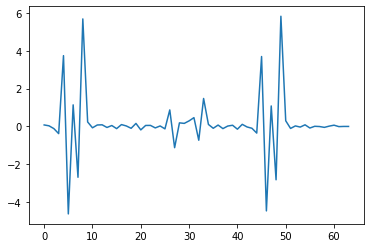

In [6]:
(xcgls, info) = TP_cgls(A, b_true, A.T@b, 20, 1e-3, x_true.reshape((-1,1)))
plt.plot(xcgls.reshape((-1,1)))
rel_residual = info['relResidual']
rel_error = info['relError']

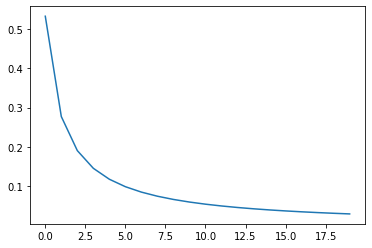

In [7]:

plt.plot(rel_residual)

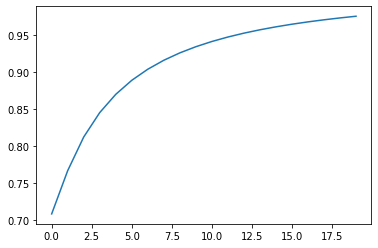

In [8]:
plt.plot(rel_error)

#### The test problem when the operator is not built expliictly

In [9]:
from trips.solvers.Hybrid_GMRES import *

In [14]:
b_vec = b.reshape((-1,1))
(x_gmres_gcv, info_gmres_gcv) = Hybrid_GMRES(A, b_vec, n_iter = 100, regparam = 'gcv', delta = delta, x_true = x_true, shape = [64, 64])
(x_gmres_dp, info_gmres_dp) = Hybrid_GMRES(A, b_vec, n_iter = 100, regparam = 'dp', delta = delta, x_true = x_true, shape = [64, 64])


running Arnoldi algorithm...: 100%|██████████| 100/100 [00:00<00:00, 244.54it/s]


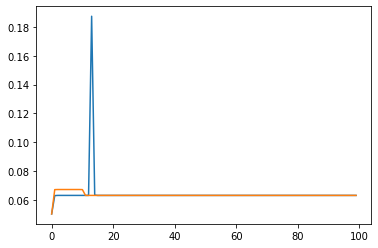

In [17]:
plt.plot(info_gmres_gcv['relError'])
plt.plot(info_gmres_dp['relError'])

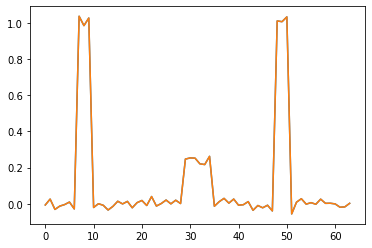

In [15]:
plt.plot(x_gmres_gcv)
plt.plot(x_gmres_dp)

### Test methods

##### 1. CGLS

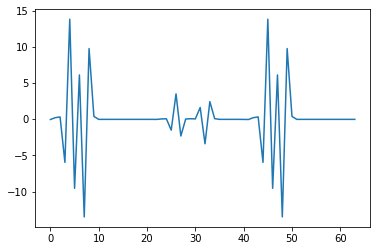

In [20]:
(xcgls, info) = TP_cgls(A, b_true, np.zeros((N,1)), 200, 1e-8, x_true)
plt.plot(xcgls.reshape(-1,1))

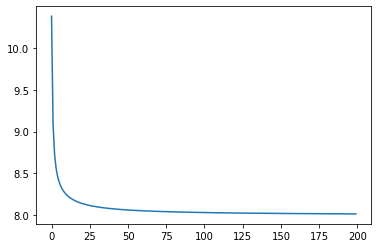

In [21]:
rel_err = info['relError']
plt.plot(rel_err)

#### 2. Arnoldi Tikhonov

In [22]:
(b, delta) = Deblur.add_noise(b_true, 'Gaussian', 0.05) # to be redefined again with the b_true corresponding to Amat

#### 3. GKS and MMGKS